<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-random-forest/blob/master/09_Amazon_Fine_Food_Reviews_Analysis_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [2]:
from google.colab import drive, files
drive.mount('/content/drive')


!cp drive/My\ Drive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 98% 246M/251M [00:03<00:00, 91.7MB/s]
100% 251M/251M [00:03<00:00, 72.0MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [20]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(103441, 10)

In [21]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

68.96066666666667

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [22]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(103441, 10)


1    90671
0    12770
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [24]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [25]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  Even if you are not a raw foodist, this bar is a healthy snack to be enjoyed by all.  I even convinced by 83 year-old father to try one and he is hooked!


In [28]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

For those on a raw diet this product is one of the best It is a simple snack made with only two ingredients dates and cashews with no preservatives Even if you are not a raw foodist this bar is a healthy snack to be enjoyed by all I even convinced by 83 year old father to try one and he is hooked 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [31]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [32]:
preprocessed_reviews[1500]

'raw diet product one best simple snack made two ingredients dates cashews no preservatives even not raw foodist bar healthy snack enjoyed even convinced year old father try one hooked'

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) #in scikit-learn
count_vect.fit(x_train)
final_counts = count_vect.transform(x_train)

final_counts_test= count_vect.transform(x_test)


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 5000)
tf_idf_vect.fit(x_train)

final_tf_idf = tf_idf_vect.transform(x_train)

final_tf_idf_test = tf_idf_vect.transform(x_test)



## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8574304580688477), ('terrific', 0.8334951400756836), ('good', 0.821617066860199), ('excellent', 0.819797694683075), ('awesome', 0.8190830945968628), ('wonderful', 0.7914049625396729), ('perfect', 0.7594773173332214), ('nice', 0.68963623046875), ('incredible', 0.6881749033927917), ('fabulous', 0.6869460940361023)]
[('greatest', 0.7938433289527893), ('best', 0.7296226620674133), ('tastiest', 0.6821034550666809), ('disgusting', 0.6185218691825867), ('terrible', 0.6180346012115479), ('awful', 0.5897429585456848), ('nastiest', 0.5888962745666504), ('nicest', 0.5845453143119812), ('closest', 0.575378954410553), ('humble', 0.575378954410553)]


In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17241
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())


sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


82752
50



20689
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df= 10, ngram_range=(1,2), max_features= 5000)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [45]:
# TF-IDF weighted Word2Vec

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [62]:
# Pickle dump

#!mkdir drive/My\ Drive/pickles

import pickle

# write a file
f = open("drive/My Drive/pickles/picklefile", "w+")
pickle.dump(final_counts, f)
pickle.dump(final_counts_test, f)
pickle.dump(final_tf_idf, f)
pickle.dump(final_tf_idf_test, f)
pickle.dump(sent_vectors, f)
pickle.dump(sent_vectors_test, f)
pickle.dump(tfidf_sent_vectors, f)
pickle.dump(tfidf_sent_vectors_test, f)
f.close()

TypeError: ignored

In [0]:
# Pickle load
import pickle

f = open("content/drive/My Drive/pickles/picklefile", "r")
final_counts = pickle.load(f)
final_counts_test = pickle.load(f)
final_tf_idf = pickle.load(f)
final_tf_idf_test = pickle.load(f)
sent_vectors = pickle.load(f)
sent_vectors_test = pickle.load(f)
tfidf_sent_vectors = pickle.load(f)
tfidf_sent_vectors_test = pickle.load(f)
f.close()

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [56]:
# Please write all the code with proper documentation

from sklearn.model_selection import RandomizedSearchCV as rsearchcv
from sklearn.ensemble import RandomForestClassifier as RF

cross= 2

train= final_counts
test= final_counts_test

depth =  [1, 5, 10, 50, 100, 500, 100]
n_estimators= [10, 100, 200, 400, 600]

estimator= RF(class_weight='balanced', n_jobs= -1)
parameters= {
    'max_depth'  : depth, 
    'n_estimators' : n_estimators
}

rand= rsearchcv(estimator, parameters, scoring='roc_auc', n_jobs=-1, cv= cross, verbose= 5, return_train_score= True, n_iter= 100)
grid= rand.fit(train, y_train)

best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_

train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc= grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_train_score']

Fitting 2 folds for each of 35 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 69.7min finished


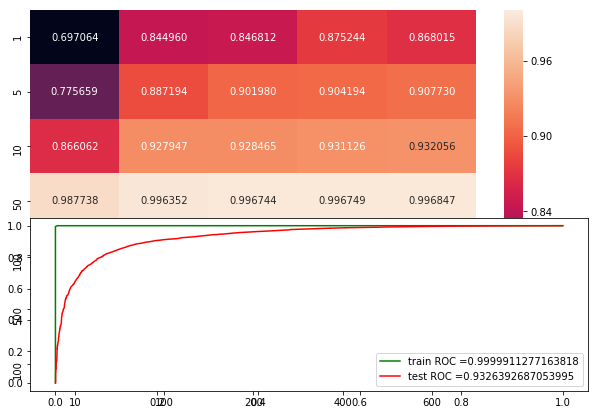

In [84]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))  
ax= sns.heatmap((np.reshape(train_auc, (7,5))), yticklabels= depth, xticklabels = n_estimators, annot=True, fmt="f")
TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

EST_BOW= grid.best_estimator_
AUC_BOW= best_score
CM_BOW= TECM


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

from sklearn.model_selection import RandomizedSearchCV as rsearchcv
from sklearn.ensemble import RandomForestClassifier as RF

cross= 2

train= final_tf_idf
test= final_tf_idf_test

depth =  [1, 5, 10, 50, 100, 500, 100]
n_estimators= [10, 100, 200, 400, 600]

estimator= RF(class_weight='balanced', n_jobs= -1)
parameters= {
    'max_depth'  : depth, 
    'n_estimators' : n_estimators
}

rand= rsearchcv(estimator, parameters, scoring='roc_auc', n_jobs=-1, cv= cross, verbose= 5, return_train_score= True, n_iter= 100)
grid= rand.fit(train, y_train)

best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_

train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc= grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_train_score']

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation

from sklearn.model_selection import RandomizedSearchCV as rsearchcv
from sklearn.ensemble import RandomForestClassifier as RF

cross= 2

train= sent_vectors
test= sent_vectors_test

depth =  [1, 5, 10, 50, 100, 500, 100]
n_estimators= [10, 100, 200, 400, 600]

estimator= RF(class_weight='balanced', n_jobs= -1)
parameters= {
    'max_depth'  : depth, 
    'n_estimators' : n_estimators
}

rand= rsearchcv(estimator, parameters, scoring='roc_auc', n_jobs=-1, cv= cross, verbose= 5, return_train_score= True, n_iter= 100)
grid= rand.fit(train, y_train)

best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_

train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc= grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_train_score']

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation

from sklearn.model_selection import RandomizedSearchCV as rsearchcv
from sklearn.ensemble import RandomForestClassifier as RF

cross= 2

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test

depth =  [1, 5, 10, 50, 100, 500, 100]
n_estimators= [10, 100, 200, 400, 600]

estimator= RF(class_weight='balanced', n_jobs= -1)
parameters= {
    'max_depth'  : depth, 
    'n_estimators' : n_estimators
}

rand= rsearchcv(estimator, parameters, scoring='roc_auc', n_jobs=-1, cv= cross, verbose= 5, return_train_score= True, n_iter= 100)
grid= rand.fit(train, y_train)

best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_

train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc= grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_train_score']

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library